In [9]:
!wget https://biostat.app.vumc.org/wiki/pub/Main/DataSets/titanic3.csv

--2022-05-18 20:15:35--  https://biostat.app.vumc.org/wiki/pub/Main/DataSets/titanic3.csv
Resolving biostat.app.vumc.org (biostat.app.vumc.org)... 160.129.8.31
Connecting to biostat.app.vumc.org (biostat.app.vumc.org)|160.129.8.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116752 (114K) [text/csv]
Saving to: ‘titanic3.csv.1’

titanic3.csv.1      100%[===================>] 114.02K  --.-KB/s    in 0.09s   

2022-05-18 20:15:36 (1.24 MB/s) - ‘titanic3.csv.1’ saved [116752/116752]



In [11]:
# reference : https://captum.ai/tutorials/Titanic_Basic_Interpret
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import grad

import matplotlib.pyplot as plt

        
# Download dataset from: https://biostat.app.vumc.org/wiki/pub/Main/DataSets/titanic3.csv
dataset_path = "titanic3.csv"
titanic_data = pd.read_csv(dataset_path)

titanic_data = pd.concat([titanic_data,
                          pd.get_dummies(titanic_data['sex']),
                          pd.get_dummies(titanic_data['embarked'],prefix="embark"),
                          pd.get_dummies(titanic_data['pclass'],prefix="class")], axis=1)
titanic_data["age"] = titanic_data["age"].fillna(titanic_data["age"].mean())
titanic_data["fare"] = titanic_data["fare"].fillna(titanic_data["fare"].mean())
titanic_data = titanic_data.drop(['name','ticket','cabin','boat','body','home.dest','sex','embarked','pclass'], axis=1)

# Set random seed for reproducibility.
np.random.seed(131254)

# Convert features and labels to numpy arrays.
labels = titanic_data["survived"].to_numpy()
titanic_data = titanic_data.drop(['survived'], axis=1)
feature_names = list(titanic_data.columns)
data = titanic_data.to_numpy()

# Separate training and test sets using 
train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]


torch.manual_seed(1)  # Set seed for reproducibility.
class TitanicSimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12, 12)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12, 8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.softmax(self.linear3(sigmoid_out2))
        
        
net = TitanicSimpleNNModel()

criterion = nn.CrossEntropyLoss()
num_epochs = 200

optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
label_tensor = torch.from_numpy(train_labels)
for epoch in range(num_epochs):    
    output = net(input_tensor)
    loss = criterion(output, label_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print ('Epoch {}/{} => Loss: {:.2f}'.format(epoch+1, num_epochs, loss.item()))
        
input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)

Epoch 1/200 => Loss: 0.70
Epoch 21/200 => Loss: 0.55
Epoch 41/200 => Loss: 0.50
Epoch 61/200 => Loss: 0.49
Epoch 81/200 => Loss: 0.48
Epoch 101/200 => Loss: 0.48
Epoch 121/200 => Loss: 0.48
Epoch 141/200 => Loss: 0.48
Epoch 161/200 => Loss: 0.47
Epoch 181/200 => Loss: 0.47


In [12]:
train_features[0]

array([29.88113767,  0.        ,  0.        ,  7.8958    ,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  1.        ])

tensor([ 47.0000,   1.0000,   0.0000, 227.5250,   0.0000,   1.0000,   1.0000,
          0.0000,   0.0000,   1.0000,   0.0000,   0.0000])
tensor([[ 47.0000,   1.0000,   0.0000, 227.5250,   0.0000,   1.0000,   1.0000,
           0.0000,   0.0000,   1.0000,   0.0000,   0.0000]])
torch.Size([1, 1, 12])
100
Index(['age', 'sibsp', 'parch', 'fare', 'female', 'male', 'embark_C',
       'embark_Q', 'embark_S', 'class_1', 'class_2', 'class_3'],
      dtype='object')


Text(0.5, 1.0, 'Graph for age')

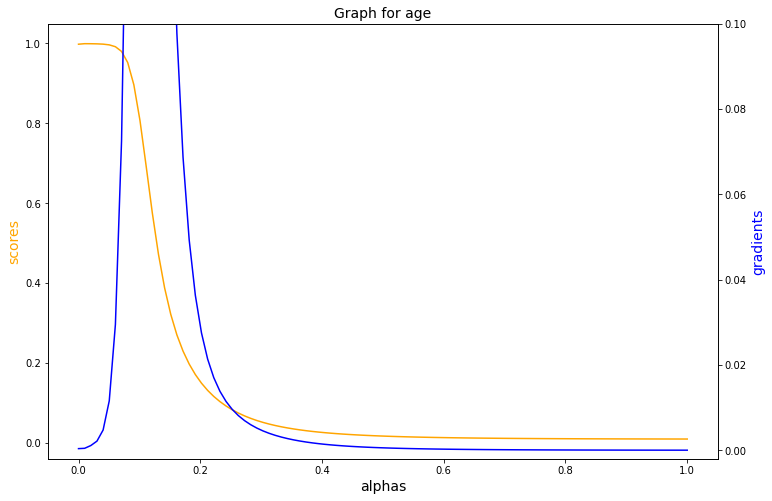

In [23]:

n_steps = 100
idx = 1

def preds_and_grads(inputs, model, baselines=None, n_steps=50, target=1, numpy=False):
    """
    function to get predictions and gradients of the output wrt features values
    
    Args:
        inputs : Tensor of inputs
        model : pytorch model
        baselines : Tensor or None of baselines 
        n_steps : int number of steps to approximate integrated gradients
        target : int target class
        numpy : bool if true return numpy, else Tensor
    """
    print(inputs[0])
    if inputs.dim() == 2:
        inputs = inputs.unsqueeze(0)
        print(inputs[0])
    if baselines == None:
        baselines = torch.zeros_like(inputs)
    
    # k/m in the formula
    alphas = torch.linspace(0, 1, n_steps).tolist()
    
    # direct path from baseline to input. shape : ([n_steps, n_features], )
    scaled_features = tuple(
            torch.cat(
                [baseline + alpha * (input - baseline) for alpha in alphas], dim=0
            ).requires_grad_()
            for input, baseline in zip(inputs, baselines)
        )
    print(inputs.size())
    print(len(scaled_features[0]))
    # predictions at every step. shape : [n_steps, 1]
    preds = model(scaled_features[0])[:, target]
    # gradients of predictions wrt input features. shape : [n_steps, n_features]
    grads = grad(outputs=torch.unbind(preds), inputs=scaled_features)
    if numpy:
        return preds.detach().numpy(), grads[0].detach().numpy()
    return preds, grads
    
preds, grads = preds_and_grads(test_input_tensor[idx:idx+1], net, n_steps=n_steps, target=1, numpy=True)

print(titanic_data.columns)
# out : Index(['age', 'sibsp', 'parch', 'fare', 'female', 'male', 'embark_C',
#       'embark_Q', 'embark_S', 'class_1', 'class_2', 'class_3'],
#      dtype='object')

alphas = np.linspace(0, 1, n_steps)
feat_n = 0 # age feature
fig,ax1 = plt.subplots(figsize=(12,8))
ax1.plot(alphas, preds, color="orange")
ax1.set_ylabel("scores",color="orange",fontsize=14)
ax2=ax1.twinx()
ax2.plot(alphas, abs(grads[:, feat_n]), color="blue")
ax2.set_ylabel("gradients",color="blue",fontsize=14)
ax2.set_ylim(-0.002, 0.1)
ax1.set_xlabel("alphas", fontsize=14)
plt.title(f"Graph for {titanic_data.columns[feat_n]}", fontsize=14)


In [22]:
test_input_tensor[1:2]

tensor([[ 47.0000,   1.0000,   0.0000, 227.5250,   0.0000,   1.0000,   1.0000,
           0.0000,   0.0000,   1.0000,   0.0000,   0.0000]])

In [ ]:
titanic_data

,age,sibsp,parch,fare,female,male,embark_C,embark_Q,embark_S,class_1,class_2,class_3
0,29.000000,0,0,211.3375,1,0,0,0,1,1,0,0
1,0.920000,1,2,151.5500,0,1,0,0,1,1,0,0
2,2.000000,1,2,151.5500,1,0,0,0,1,1,0,0
3,30.000000,1,2,151.5500,0,1,0,0,1,1,0,0
4,25.000000,1,2,151.5500,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,14.500000,1,0,14.4542,1,0,1,0,0,0,0,1
1305,29.881138,1,0,14.4542,1,0,1,0,0,0,0,1
1306,26.500000,0,0,7.2250,0,1,1,0,0,0,0,1
1307,27.000000,0,0,7.2250,0,1,1,0,0,0,0,1


In [ ]:
print(grads[:, feat_n].mean(0)* test_features[idx][feat_n])
# out : [-0.47125493735074997]

# if we want to compute it as in the formula:
"""
products = []
for el in grads[:, feat_n]:
    products.append(el * test_features[idx][feat_n])
print(sum(products)/n_steps)
"""

# attributions for all features
print(grads.mean(0)* test_features[idx])
# out : array([-0.47125498, -0.09514174, -0.        , -0.04347427,  0.        ,
#       -0.76860356,  0.05644951,  0.        , -0.        ,  0.36232147,
#        0.        , -0.        ])
# so age, sibsp, fare and embark_C have negative effect on the prediction pushing the probability 
# down while the fact that the person belongs to class 1 is pushing the probability up

"""
NB : there are different ways to approximate an integral. Because we averaged the gradients to compute attributions (step sizes all 
equally weighted, i.e. 1/n), we need to use ` method='riemann_trapezoid' ` that has approximately step sizes = 1/n (see
https://github.com/pytorch/captum/blob/69a6a9487de459cd0647a86990cab631f3096602/captum/attr/_utils/approximation_methods.py#L68 for 
more details) to compare our results to the ones in captum library.
from captum.attr import IntegratedGradients
preds, grads = preds_and_grads(test_input_tensor[idx:idx+1], net, n_steps=30000, target=1, numpy=True)
ig = IntegratedGradients(net)
np.allclose(ig.attribute(test_input_tensor[idx:idx+1], target=1, method='riemann_trapezoid', n_steps=30000).squeeze(0).detach().numpy(), 
            grads.mean(0)* test_features[idx], atol=1e-06)
"""

-1.289970399811864
[-1.28997057 -0.0458256   0.          0.59897745  0.         -0.5737462
  0.12217938 -0.         -0.          0.23639333  0.         -0.        ]


"\nNB : there are different ways to approximate an integral. Because we averaged the gradients to compute attributions (step sizes all \nequally weighted, i.e. 1/n), we need to use ` method='riemann_trapezoid' ` that has approximately step sizes = 1/n (see\nhttps://github.com/pytorch/captum/blob/69a6a9487de459cd0647a86990cab631f3096602/captum/attr/_utils/approximation_methods.py#L68 for \nmore details) to compare our results to the ones in captum library.\nfrom captum.attr import IntegratedGradients\npreds, grads = preds_and_grads(test_input_tensor[idx:idx+1], net, n_steps=30000, target=1, numpy=True)\nig = IntegratedGradients(net)\nnp.allclose(ig.attribute(test_input_tensor[idx:idx+1], target=1, method='riemann_trapezoid', n_steps=30000).squeeze(0).detach().numpy(), \n            grads.mean(0)* test_features[idx], atol=1e-06)\n"